# Convolutional Neural Network - Gap / Char Classification
Using TensorFlow

Also need to convert images in folder into csv data file

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

# Creating CSV
import glob
import csv

print("OpenCV: " + cv2.__version__)
print("Numpy: " + np.__version__)
print("TensorFlow: " + tf.__version__)

OpenCV: 3.1.0-dev
Numpy: 1.12.0
TensorFlow: 1.0.0-rc1


In [2]:
def implt(img, cmp=None, t=''):
    """ Show image using plt """
    plt.imshow(img, cmap=cmp)
    plt.title(t)
    plt.show()

## Load Images and Lables in CSV

In [3]:
# 755 chars and 306 gaps images, dimension 30x60 = 1800
# Or read_csv() form pandas
images = np.genfromtxt('data/gapdet/data.csv', delimiter=',')
labels = np.genfromtxt('data/gapdet/labels.csv', delimiter=',')
labels = np.reshape(labels, (len(labels), 1))

print("CSV data files loaded.")
print("Number of images: " + str(len(images)))

trainData = images[0:700]
trainLabels = labels[0:700]
evalData = images[700:]
evalLabels = labels[700:]

CSV data files loaded.
Number of images: 1061


# Create classifier

In [4]:
# Place holders for data and labels
x = tf.placeholder(tf.float32, [None, 1800])
y_ = tf.placeholder(tf.float32, [None, 1])

# Learned variables
W = tf.Variable(tf.random_normal([1800, 1]), name="W")
b = tf.Variable(tf.random_normal([1]), name="b")

y = tf.matmul(x, W) + b

# Training Model
cross_entropy = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_, logits=y, name="Cost"))
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

# For saving and using model
activation = tf.sigmoid(y)
tf.add_to_collection("act", activation)

for i in range(1000):
    sess.run(train_step, feed_dict={x: trainData, y_: trainLabels})
    if i % 100 == 0:
        print("Cost: " + str(sess.run(cross_entropy, feed_dict={x: trainData, y_: trainLabels})))

# Saving model
tf.train.export_meta_graph('models/CGClassifier')

# Evaluating model
correct_prediction = tf.equal(tf.sigmoid(y) , y_)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

print("Eval accuracy: %g" % sess.run(accuracy, feed_dict={x: evalData, y_: evalLabels}))
print("Total accuracy: %g" % sess.run(accuracy, feed_dict={x: images, y_: labels}))

Cost: 41702.4
Cost: 3822.6
Cost: 0.0
Cost: 0.0
Cost: 0.0
Cost: 0.0
Cost: 0.0
Cost: 0.0
Cost: 0.0
Cost: 0.0
Eval accuracy: 0.786704
Total accuracy: 0.927427


[[ 0.]]


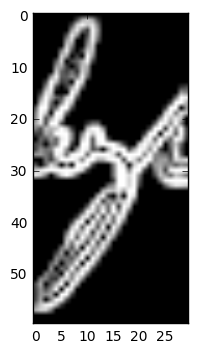

In [32]:
img = 14
res = sess.run(tf.sigmoid(y), feed_dict={x: np.reshape(images[img], (1, 1800))})
print(res)
        
implt(np.reshape(images[img], (60, 30)), 'gray')

In [33]:
def sofmaxLabels(lab):
    """ Transform data for sofmax classification """
    newLab = np.zeros((len(lab), 2), dtype=np.int8)
    for i in range(len(lab)):
        newLab[i][int(lab[i][0])] = 1
    return newLab

llabels = sofmaxLabels(labels)
trainLabels = llabels[0:700]
evalLabels = llabels[700:]

In [35]:
sess = tf.InteractiveSession()

x = tf.placeholder(tf.float32, [None, 1800])
y_ = tf.placeholder(tf.float32, [None, 2])

W = tf.Variable(tf.random_normal([1800, 2]))
b = tf.Variable(tf.random_normal([2]))

y = tf.matmul(x,W) + b

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))

train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)


sess.run(tf.global_variables_initializer())

for i in range(1000):
    sess.run(train_step, feed_dict={x: trainData, y_: trainLabels})
    if i % 100 == 0:
        print("Cost: " + str(sess.run(cross_entropy, feed_dict={x: trainData, y_: trainLabels})))

    
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print("Eval accuracy: %g" % sess.run(accuracy, feed_dict={x: evalData, y_: evalLabels}))
print("Total accuracy: %g" % sess.run(accuracy, feed_dict={x: images, y_: llabels}))

Cost: 122183.0
Cost: 9915.86
Cost: 128.199
Cost: 0.0
Cost: 0.0
Cost: 0.0
Cost: 0.0
Cost: 0.0
Cost: 0.0
Cost: 0.0
Eval accuracy: 0.797784
Total accuracy: 0.931197


In [20]:
sess = tf.InteractiveSession()

x = tf.placeholder(tf.float32, [None, 1800])

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

x_image = tf.reshape(x, [-1, 30, 60, 1])

# 1. Layer
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# 2. Layer
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# Connected layer
W_fc1 = weight_variable([8 * 15 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 8*15*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# Dropout
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# Output layer
W_fc2 = weight_variable([1024, 2])
b_fc2 = bias_variable([2])

y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
y_ = tf.placeholder(tf.float32, [None, 2])

# Train
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv + 1e-10))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)   # 1e-4 - default

correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

sess.run(tf.global_variables_initializer())

for i in range(400):
    if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={x: trainData, y_: trainLabels, keep_prob: 1.0})
        print("step %d, training accuracy %g" % (i, train_accuracy))
    train_step.run(feed_dict={x: trainData, y_: trainLabels, keep_prob: 0.5})

print("test accuracy %g" % accuracy.eval(feed_dict={x: evalData, y_: evalLabels, keep_prob: 1.0}))


step 0, training accuracy 0.648571
step 100, training accuracy 0.697143
step 200, training accuracy 0.697143
step 300, training accuracy 0.697143
test accuracy 0.739612


In [22]:
print(sess.run(cross_entropy, feed_dict={x: images, y_: llabels, keep_prob: 1.0}))

7045.92
7045.92
7045.92
